# Лабораторная работа №1. Регрессия

**Тема:** *Сравнение линейной регрессии, случайного леса (Random Forest Regressor), градиентного бустинга (XGBoost) на задаче регрессии.*

**Цели:**

- *Научиться строить, оптимизировать и оценивать регрессионные модели.*
- *Понять, как интерпретировать важность признаков (feature importance).*
- *Понять, как увеличивать кол-во признаков (feature tuning).*
- *Исследовать влияние преобразований признаков (фичей), регуляризации и гиперпараметров.*

**Условия:**

- *numpy, pandas, scikit-learn, XGBoost*
- *выбрать датасет для 1-ой и 2-ой лабораторной работы*

**Пункты:**

1. Подготовка данных + Feature Tuning
2. Создание метрик
3. Базовая модель линейной регрессии
4. Улучшение линейной регрессии
5. Случайный лес регрессор
6. Градиентный бустинг (XGBoost)
7. Feature Importance
8. Написание своих реализаций (классы)
9. Подведение итогов


## О команде

| Фамилия И.О.        | Группа | Роль в команде | Что делал                    |
|---------------------|--------|----------------|------------------------------|
| Люзина М.Н.         | 307    | Solo way       | Все сам                      |

 Датасет: [california-housing-prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices?utm_source=chatgpt.com)

## Описание датасета

Датасет California Housing Prices содержит данные о ценах на жильё в различных районах Калифорнии, основанные на данных переписи населения 1990 года. Он широко используется для задач регрессии, где цель — предсказать медианную стоимость дома в районе на основе социально-экономических и географических характеристик.

Цель задачи — построить предсказательную модель, которая ответит на вопрос: «Каковы факторы, влияющие на медианную стоимость жилья в районе?» Для этого используются такие признаки, как средний доход жителей, количество комнат, возраст домов и географическое положение.

---

### Таблица признаков

| №  | Признак                  | Тип данных     | Описание                                                                               |
| -- | ------------------------ | -------------- | -------------------------------------------------------------------------------------- |
| 1  | **longitude**        | float          | Долгота географического положения района (в градусах). |
| 2  | **latitude**     | float         | Широта географического положения района (в градусах).     |
| 3  | **housing_median_age**          | float         | Медианный возраст домов в районе (в годах).                         |
| 4  | **total_rooms**       | float          | Общее количество комнат во всех домах в районе.                        |
| 5  | **total_bedrooms**            | float          | Общее количество спален во всех домах в районе.              |
| 6  | **population**  | float          | Общее население района.                |
| 7  | **households** |float         | Общее количество домохозяйств в районе.          |
| 8  | **median_income**              | float         | Медианный доход домохозяйств в районе (в десятках тысяч долларов США).                               |
| 9  | **median_house_value**                   | float          | Целевая переменная: медианная стоимость дома в районе (в долларах США).          |
| 10  | **ocean_proximity**                   | object         | Близость дома к океану/морю: категориальный признак с значениями 'NEAR BAY', 'NEAR OCEAN', 'INLAND', '<1H OCEAN', 'ISLAND'.          |


## 0. Глобальная настройка проекта


In [92]:
RND_SEED = 21
USE_AUTO_POLY = True

## 1. Подготовка данных + Feature Tuning

### 1.1. Загрузка датасета

Подключим необходимые библиотеки


In [93]:
import pandas as pd
import numpy as np
import math
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from math import radians, sin, cos, sqrt, atan2

Добавим датасет локально и загрузим его

In [94]:
file_path = Path('housing.csv')
df = pd.read_csv(file_path)

### 1.2. Сбор основной информации

Выведем первые 3 строки датасета `df.head(3)`

In [95]:
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000,NEAR BAY
1,-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000,NEAR BAY
2,-122.240000,37.850000,52.000000,1467.000000,190.000000,496.000000,177.000000,7.257400,352100.000000,NEAR BAY


Получение общей информации `df.info()`

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Получение всей статистики `df.describe()`

In [97]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Проверка на пропуски данных `df.isnull().sum()`

In [98]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Посмотрим на распределение целевой переменной

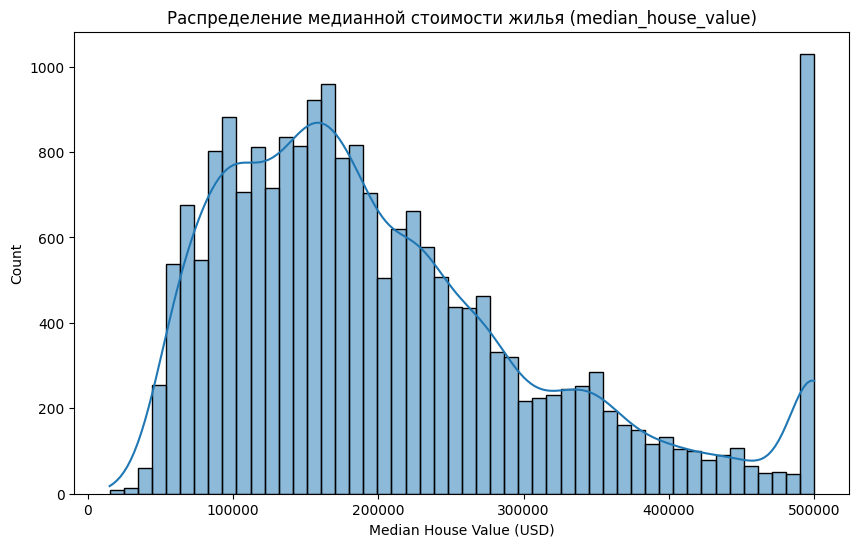

In [99]:
plt.figure(figsize=(10, 6))
sns.histplot(df['median_house_value'], bins=50, kde=True)
plt.title('Распределение медианной стоимости жилья (median_house_value)')
plt.xlabel('Median House Value (USD)')
plt.ylabel('Count')
plt.show()

**Вывод:**

1. Общая информация

    * **Размер датасета**: 20460 наблюдения (районов Калифорнии).
    * **Целевая переменная (median_house_value)**: принимает значения от **~15,000 до ~500,000** долларов США, со средним ≈ **206,855**.
    
        -> Распредление скошено вправо, с пиком около 500,000 → возможно, **искуственное ограчинение данных**. 
    
        -> Большинство домов имеют **среднюю стоимость** в диапазоне 100,000 - 300,000 долларов.

        -> Экстремально дорогие дома (> 450,000) редки → потенциальные **выбросы**.

2. Георграфические признаки

    * **longitude** (долгота):

        * Среднее ≈ -119.57, варьируется от -124.35 до -114.31.
        * Отражает географическое положение районов вдоль побережья Калифорнии.

    * **latitude** (широта):

        * Среднее ≈ 35.63, варьируется от 32.54 до 41.95.
        * Вместе с **longitude** может указывать на близость к дорогим прибрежным зонам (Например, Сан-Франциско или Лос-Анджелес).
        * Потенциально коррелирует с **median_house_value**, так как прибрежные районы дороже.

3. Характеристики жилья

    * **housing_median_age** (медианный возраст домов):

        * Среднее ≈ 28.64 лет, варьируется от 1 до 52.
        * Большинство домов построены 20-40 лет назад.
        * Старые дома (>50 лет) редки и могут быть менее ценными, если не в исторических районах.

    * **total_rooms** (общее количество комнат):

        * Среднее ≈ 2635.8, но разброс огромный (от 2 до 39,320).
        * Высокие значения указывают на крупные районы, но могут быть **выбросами**
    
    * **total_bedrooms** (общее количество спален):

        * Среднее ≈ 537.9, варьируется от 1 до 6,445.
        * Пропуски (~207 записей, 1%) требуют заполнения, например, медианой.
        * Вероятно, сильно коррелирует с **total_rooms** и **households**.

4. Социально-экономические показатели

    * **population** (население района):

        * Среднее ≈ 1425.5, варьируется от 3 до 35.682.
        * Экстремальные значения (>10,000) редки → потенциальные **выбросы**.
        * Может коррелировать с **households** и **total_rooms**.

    * **households** (количество домохозяйств):

        * Среднее ≈ 499.5, варьируется от 1 до 6,082.
        * Высокая корреляция с **total_rooms** и **total_bedrooms** → возможно, стоит заменить производными признаками.

    * **median_income** (медианный доход):

        * Среднее ≈ 3.87 (в десятках тысяч долларов), варьируется от 0.5 до 15.
        * Скорее всего, сильно коррелирует с **median_house_value**, так как более высокий доход жителей связан с более дорогим жильем.

5. Категоральный признак

    * **ocean_proximity** (близость к океану):

        * Категоральный признак с 5 уникальныии значениями: 'NEAR BAY', 'NEAR OCEAN', 'INLAND', '<1H OCEAN', 'ISLAND'.
        * Прибрежные районы вероятно имеют более высокую стоимость жилья, чем внутренние.
        * Требует кодирования для использования в моделях.


Заполним пропуски в `total_bedrooms` медианой

In [100]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

Проверим успешность заполнения пропусков


In [101]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Выполним кодирование категориального признака `ocean_proximity`, так как корреляционная матрица работает только с числовыми переменными.

In [102]:
df_encoded = pd.get_dummies(df, columns=['ocean_proximity'], prefix='ocean_proximity')
df_encoded = df.drop(columns=['ocean_proximity'])
df_encoded.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000
1,-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000
2,-122.240000,37.850000,52.000000,1467.000000,190.000000,496.000000,177.000000,7.257400,352100.000000


Посмотрим на корреляцию данных.

***Определение 1: Корреляция данных — это статистическая мера, показывающая, насколько и в каком направлении связаны между собой две переменные.***

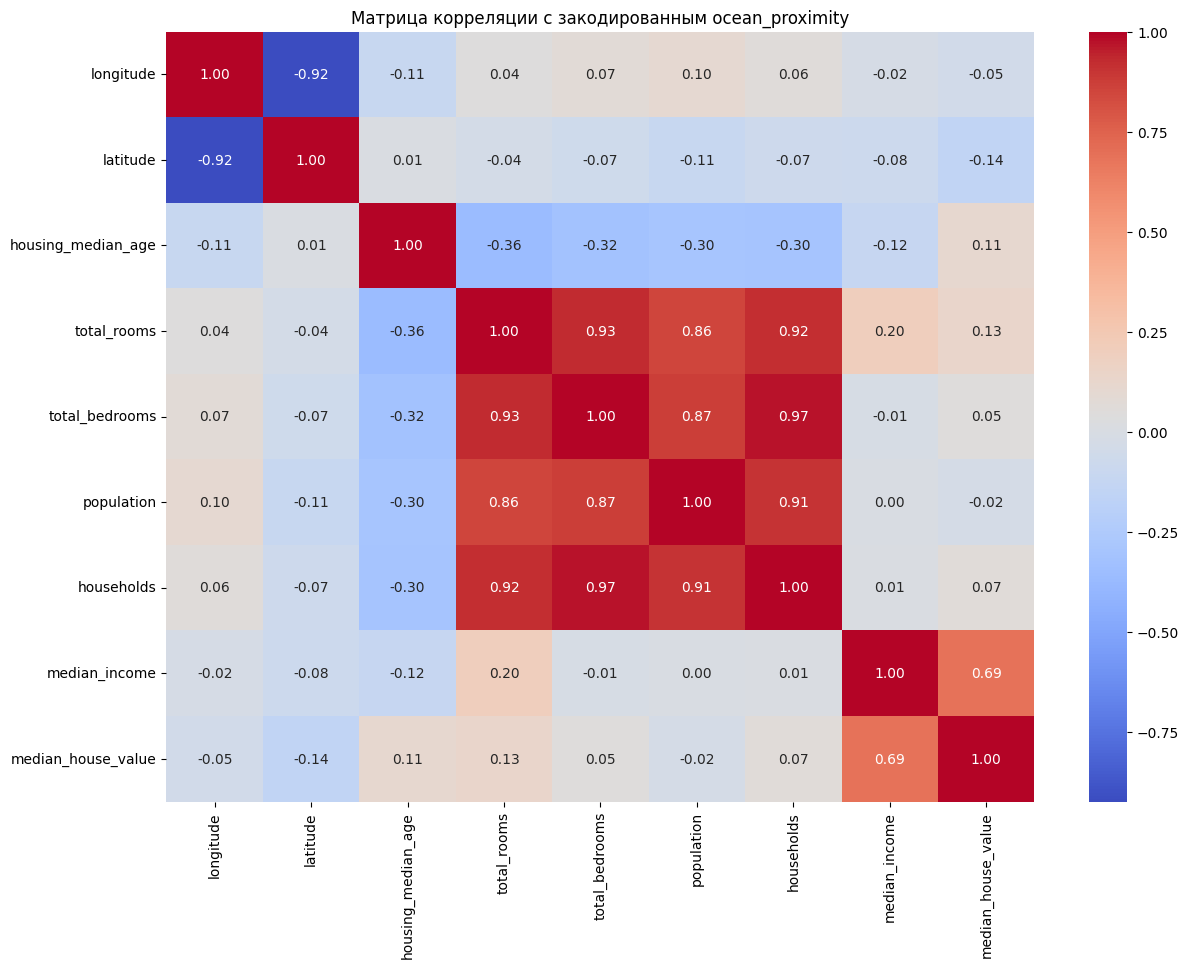

In [103]:
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции с закодированным ocean_proximity')
plt.show()

**Вывод по корреляции:**

1. Сильная корреляция с целевой переменной (**madian_house_value**):
    
    * **median_income** демонстрирует высокую положительную корреляцию (~0.69), что указывает на значительное влияние среднего дохода жителей на стоимость жилья в районе. Районы с более высоким доходом имеют более дорогие дома.

    * Закодированные категории **ocean_proximity_<1H_OCEAN** (~0.26) и **ocean_proximity_NEAR_BAY** (~0.16) показывают умеренную положительную корреляцию, что подтверждает, что дома, расположенные ближе к океану или заливу, дороже.

    * **ocean_proximity_NEAR_OCEAN** имеет слабую положительную корреляцию (~0.15), а **ocean_proximity_ISLAND** — почти нулевую (~0.01) из-за малого количества наблюдений в этой категории.

    * Числовые признаки, такие как **housing_median_age** (~0.11), **total_rooms** (~0.13) и **households** (~0.07), имеют слабую положительную корреляцию с median_house_value, что говорит о минимальном прямом влиянии этих факторов на цену в их текущем виде

2. Мультиколлинеарность:

    * Высокая корреляция наблюдается между **total_rooms** и **total_bedrooms** (~0.93), **total_rooms** и **households** (~0.92), **total_bedrooms** и **households** (~0.92), а также **population** и **households** (~0.91). Это указывает на сильную избыточность этих признаков, что может привести к нестабильности коэффициентов в линейной регрессии.

    * **longitude** и **latitude** имеют сильную отрицательную корреляцию (~-0.92), что связано с географической структурой Калифорнии: долгота уменьшается, а широта увеличивается вдоль побережья.

    * **housing_median_age** имеет слабую отрицательную корреляцию с **total_rooms** (~-0.36) и **total_bedrooms** (~-0.32), что может указывать на меньшее количество комнат в старых домах.

3. Влияние категориального признака (**ocean_proximity**):

    * Закодированные столбцы **ocean_proximity_<1H_OCEAN**, **ocean_proximity_NEAR_BAY**, **ocean_proximity_NEAR_OCEAN** и **ocean_proximity_ISLAND** имеют отрицательные корреляции между собой, что логично, так как районы не могут принадлежать к нескольким категориям одновременно.

    * **ocean_proximity_<1H_OCEAN** и **ocean_proximity_NEAR_BAY** положительно коррелируют с **median_house_value**, тогда как их отрицательная корреляция с внутренними районами (косвенно через исключённый INLAND) подтверждает более низкую стоимость жилья во внутренних районах.



### 1.3. Подготовка датасета под разные задачи

Cравнение подготовки

| Модель                  | Масштабирование | Корреляция критична | Выбросы критичны | Feature Engineering рекомендуем                  |
| ----------------------- | --------------- | ------------------- | ---------------- | ------------------------------------------------ |
| Линейная регрессия      | Да              | Да                  | Да               | Полиномы, логарифмы, отношения                   |
| Random Forest Regressor | Нет             | Нет                 | Нет              | Соотношения, интеракции                          |
| XGBoost Regressor       | Нет             | Нет                 | Нет              | Соотношения, интеракции, логарифмы (опционально) |

#### 1.3.1 Линейная регрессия (Linear Regression / Ridge / Lasso)

**Особенности модели:**

- Чувствительна к масштабу признаков и мультиколлинеарности.
- Чувствительна к выбросам.

Сделаем копию датасета

In [104]:
df_linear = df_encoded.copy()

Визуализируем выбросы, написав функцию для построения ящиковых диаграмм. Категориальный признак **ocean_proximity** уже подготовлен для модели через `pd.get_dummies` и не нуждается в дополнительной обработке выбросов и скошенности


Ящиковые диаграммы для числовых признаков (выбросы):


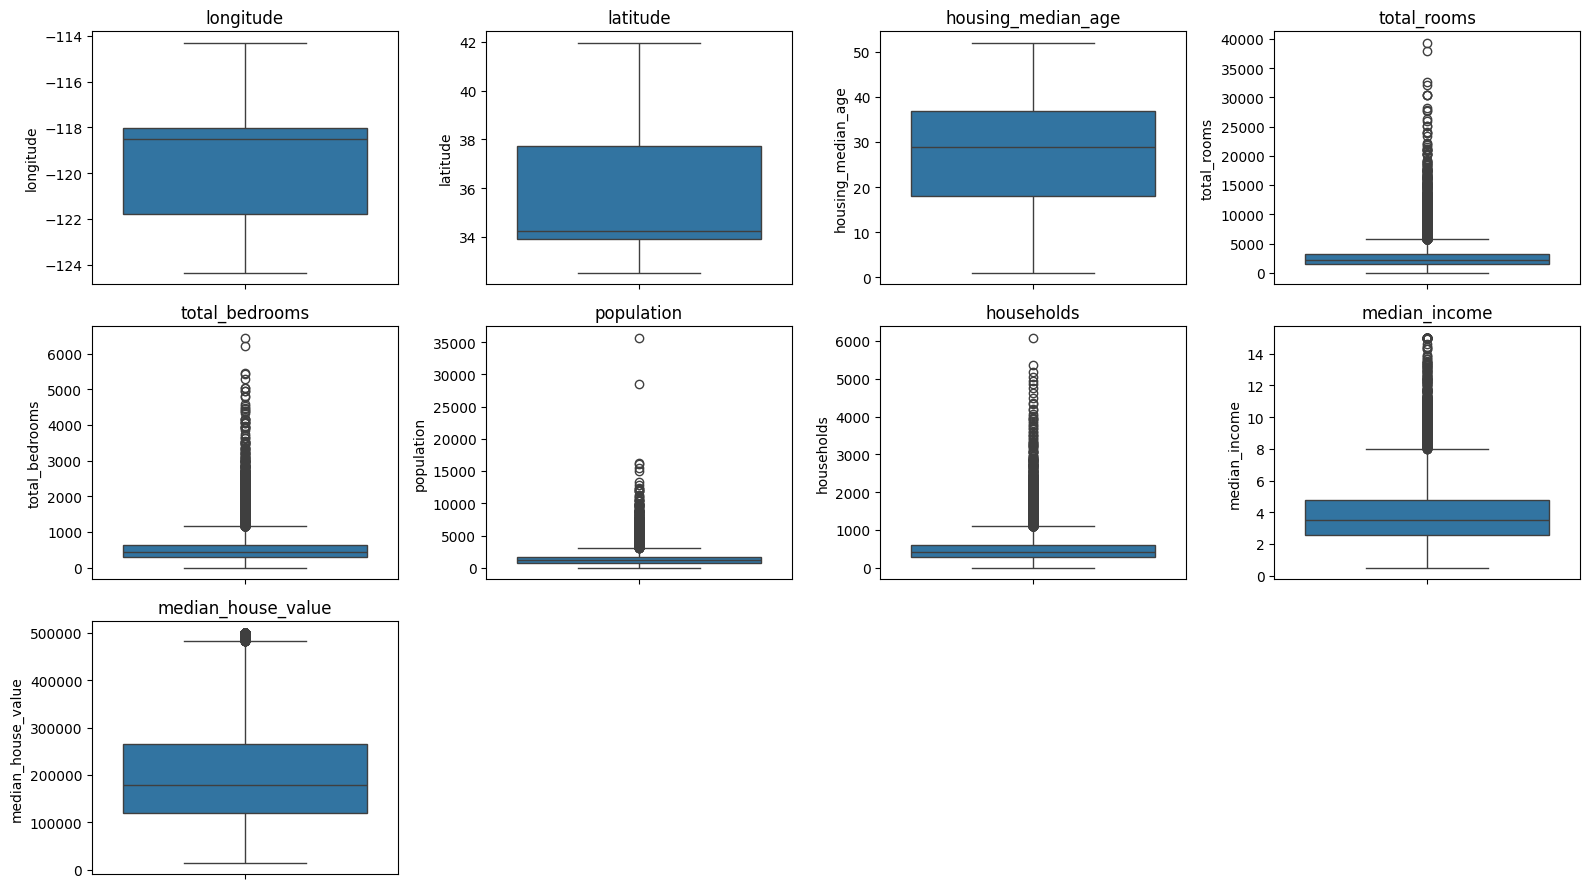

In [105]:
def draw_boxplots(df: pd.DataFrame, n_cols=4):
    float_cols = df.select_dtypes(include='float').columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()

    for i, col in enumerate(float_cols):
        sns.boxplot(y=df[col], ax=axs[i])
        axs[i].set_title(f'{col}')

    # Скрываем лишние ячейки
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

print("\nЯщиковые диаграммы для числовых признаков (выбросы):")
draw_boxplots(df_linear)

Удаляем выбросы

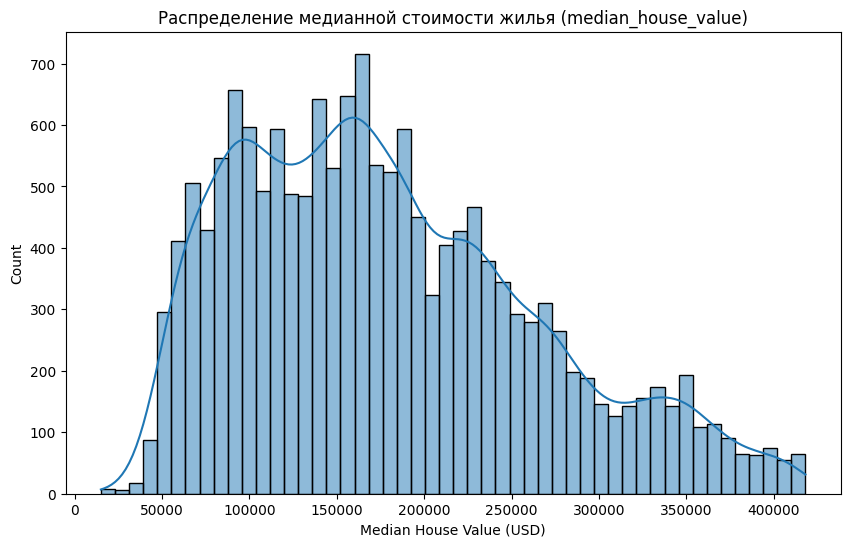

In [108]:
def remove_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
    Q1 = df_linear[column].quantile(0.25)
    Q3 = df_linear[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_linear[(df_linear[column] >= lower_bound) & (df_linear[column] <= upper_bound)]

# Применяем удаление выбросов к числовым признакам
float_cols = df_linear.select_dtypes(include='float').columns
for col in float_cols:
    df_linear = remove_outliers(df_linear, col)

plt.figure(figsize=(10, 6))
sns.histplot(df_linear['median_house_value'], bins=50, kde=True)
plt.title('Распределение медианной стоимости жилья (median_house_value)')
plt.xlabel('Median House Value (USD)')
plt.ylabel('Count')
plt.show()

Проверим размер данных после удаления выбросов

In [33]:
print("\nРазмер данных после удаления выбросов:", df_linear.shape)


Размер данных после удаления выбросов: (16896, 9)



Ящиковые диаграммы числовых признаков после удаления выбросов:


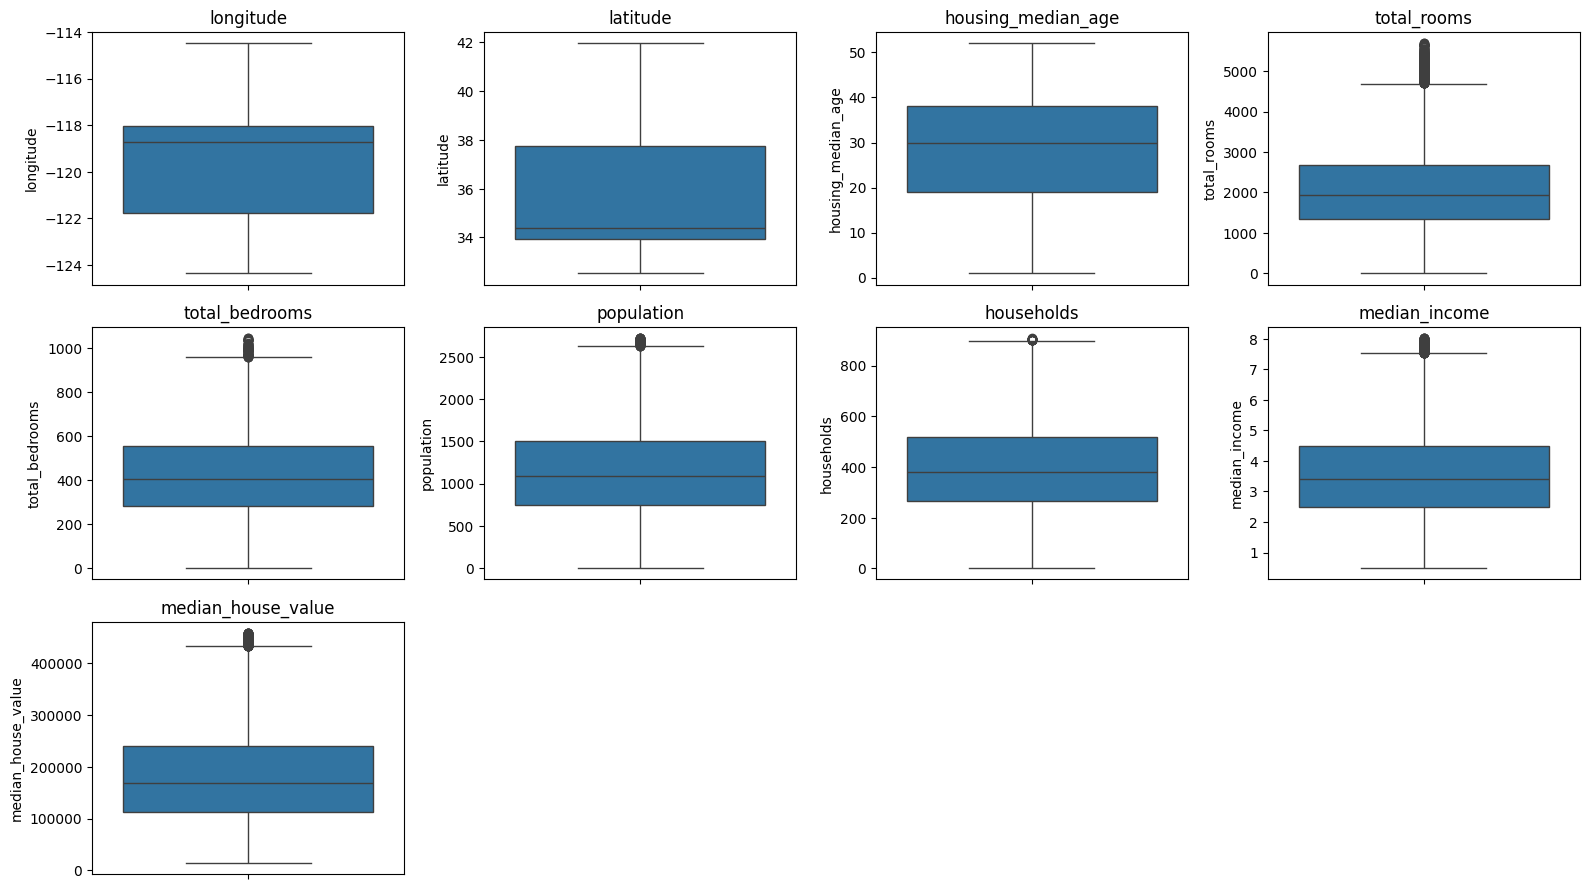

In [34]:
print("\nЯщиковые диаграммы числовых признаков после удаления выбросов:")
draw_boxplots(df_linear)

Рассмотрим скошенность данных

***Определение 2: Скошенность – это мера асимметрии распределения признака***

* **Скошенность > 0 (положительная):** Хвост распределения тянется вправо (большие значения встречаются реже).

* **Скошенность < 0 (отрицательная):** Хвост распределения тянется влево (малые значения редки).

* **Скошенность ≈ 0:** Практически нормальное распределение (симметричное).


In [35]:
# Вычисляем коэффициенты асимметрии для числовых признаков
skew_values = df_linear.select_dtypes(include='float').skew()
skew_values_hard = skew_values[abs(skew_values) > 0.5]  # Выделяем сильно скошенные признаки
print("Сильно скошенные признаки (|skew| > 0.5):")
print(skew_values_hard)

# Список сильно скошенных столбцов
skew_columns_hard = list(skew_values_hard.index)
print(f'Скошенные столбцы: {skew_columns_hard}')

Сильно скошенные признаки (|skew| > 0.5):
total_rooms           0.604721
median_income         0.554373
median_house_value    0.716980
dtype: float64
Скошенные столбцы: ['total_rooms', 'median_income', 'median_house_value']


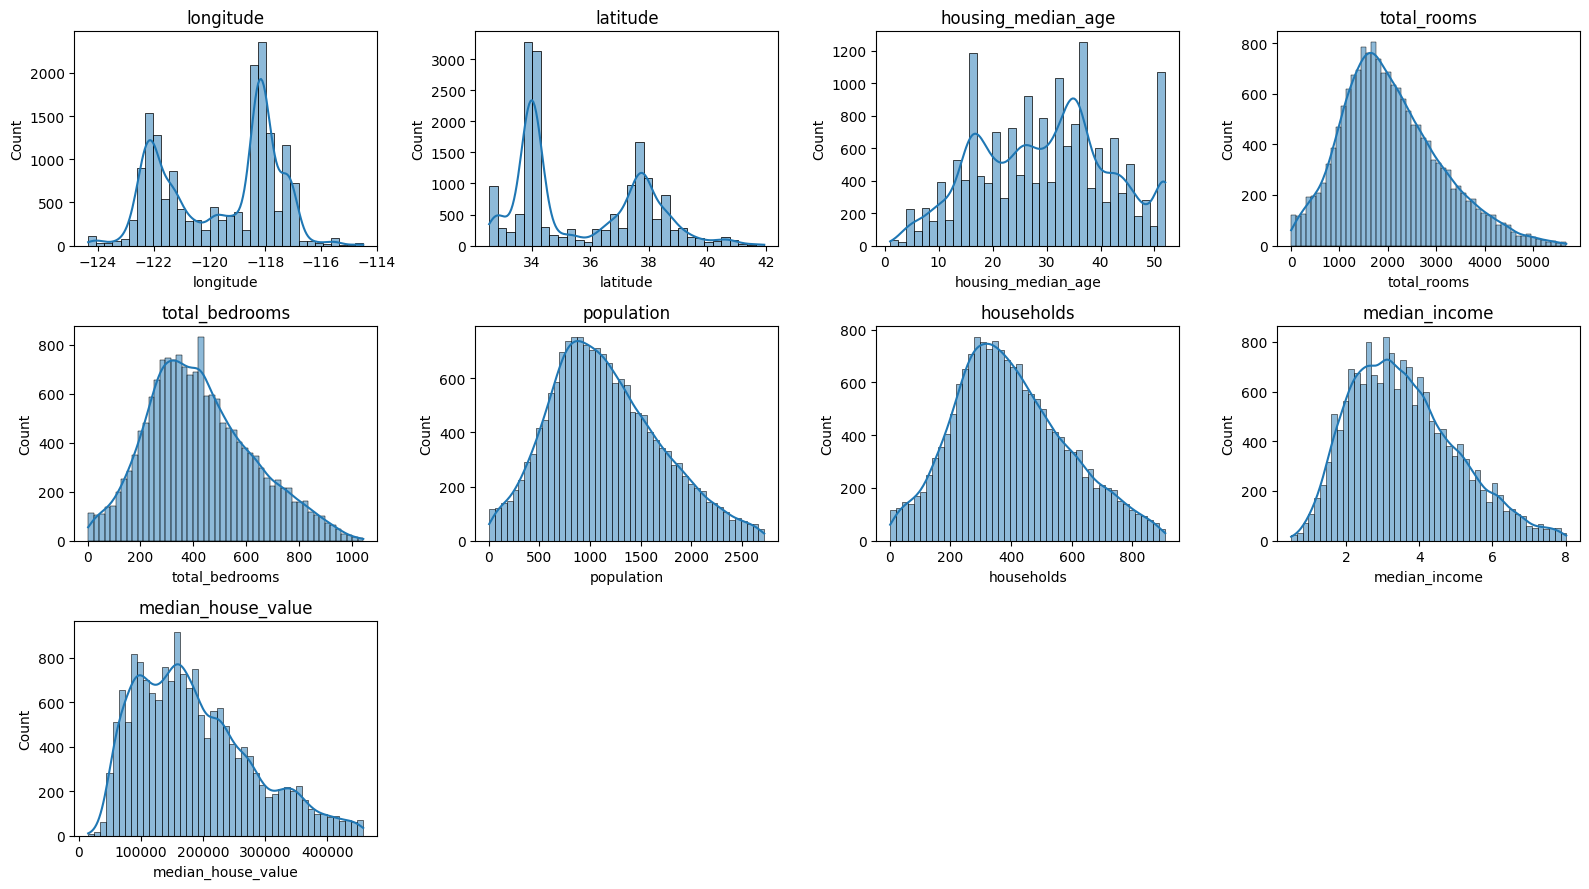

In [36]:
def draw_skew(df: pd.DataFrame, n_cols=4):
    float_cols = df.select_dtypes(include='float').columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # Делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df_linear[col], kde=True, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Скрываем лишние ячейки, если графиков меньше
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# Строим гистограммы для числовых признаков
draw_skew(df_linear)

In [37]:
for col in skew_columns_hard:
    # Проверяем, что значения положительные, чтобы избежать log(0) или log(отрицательного)
    if (df_linear[col] > 0).all():
        df_linear[col] = np.log1p(df_linear[col])  # log1p = log(1 + x) для стабильности
    else:
        print(f"Признак {col} содержит неположительные значения, пропускаем логарифмирование")

# Повторно вычисляем скошенность после преобразования
skew_values_after = df_linear.select_dtypes(include='float').skew()
print("\nСкошенность после логарифмирования:")
print(skew_values_after[skew_columns_hard])



Скошенность после логарифмирования:
total_rooms          -1.962719
median_income        -0.171502
median_house_value   -0.322487
dtype: float64


Визуализируем распределение после логарифмирования


Гистограммы числовых признаков после обработки скошенности:


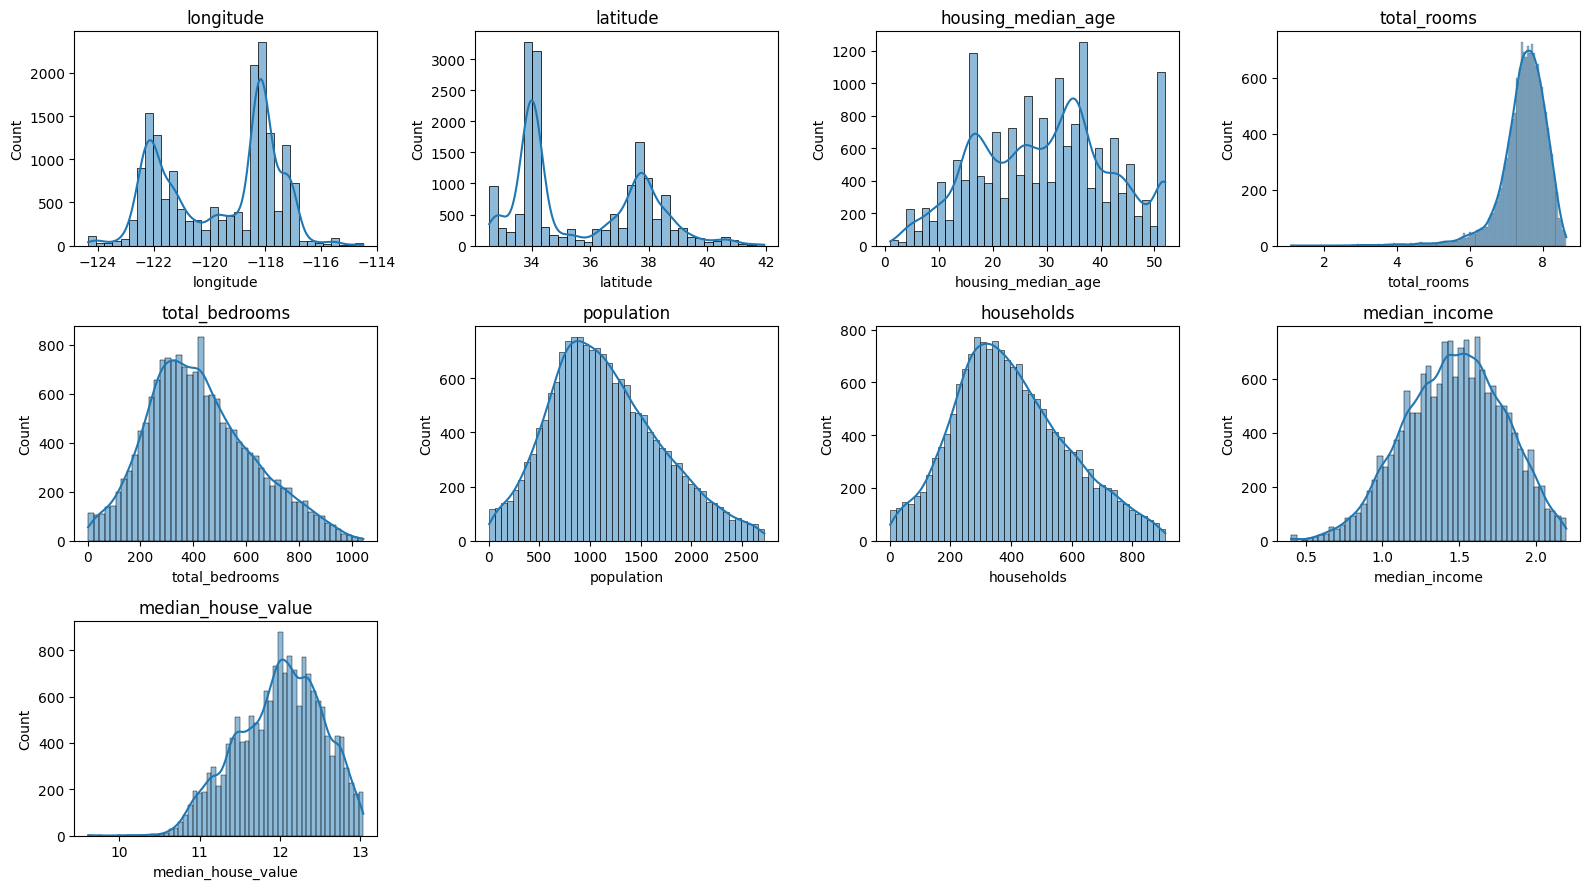

In [38]:
print("\nГистограммы числовых признаков после обработки скошенности:")
draw_skew(df_linear)

Все признаки теперь имеет распределение, близкое к нормальному, исключая **total_rooms**. Это указывает на перекомпенсацию при логарифмировании, значение `skew` = -1.96 выходит за пределы приемлего диапазона [-0.5, 0.5], что не оптимально для линейной регрессии. Поэтому мы применим Jae-Johnson преобразование к логарифмированному **total_rooms**

In [39]:
pt = PowerTransformer(method='yeo-johnson')
df_linear['total_rooms'] = pt.fit_transform(df_linear[['total_rooms']])

Проверим скошенность **total_rooms**

In [40]:
skew_total_rooms_after = df_linear['total_rooms'].skew()
print("\nСкошенность total_rooms после Yeo-Johnson преобразования:", skew_total_rooms_after)


Скошенность total_rooms после Yeo-Johnson преобразования: -0.039714452573995494


Визуализируем распределение **total_rooms** после преобразований

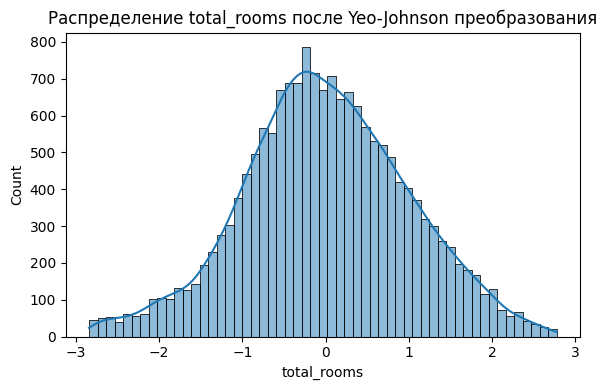

In [41]:
plt.figure(figsize=(6, 4))
sns.histplot(df_linear['total_rooms'], kde=True)
plt.title('Распределение total_rooms после Yeo-Johnson преобразования')
plt.tight_layout()
plt.show()

Устраним мультикорреляцию


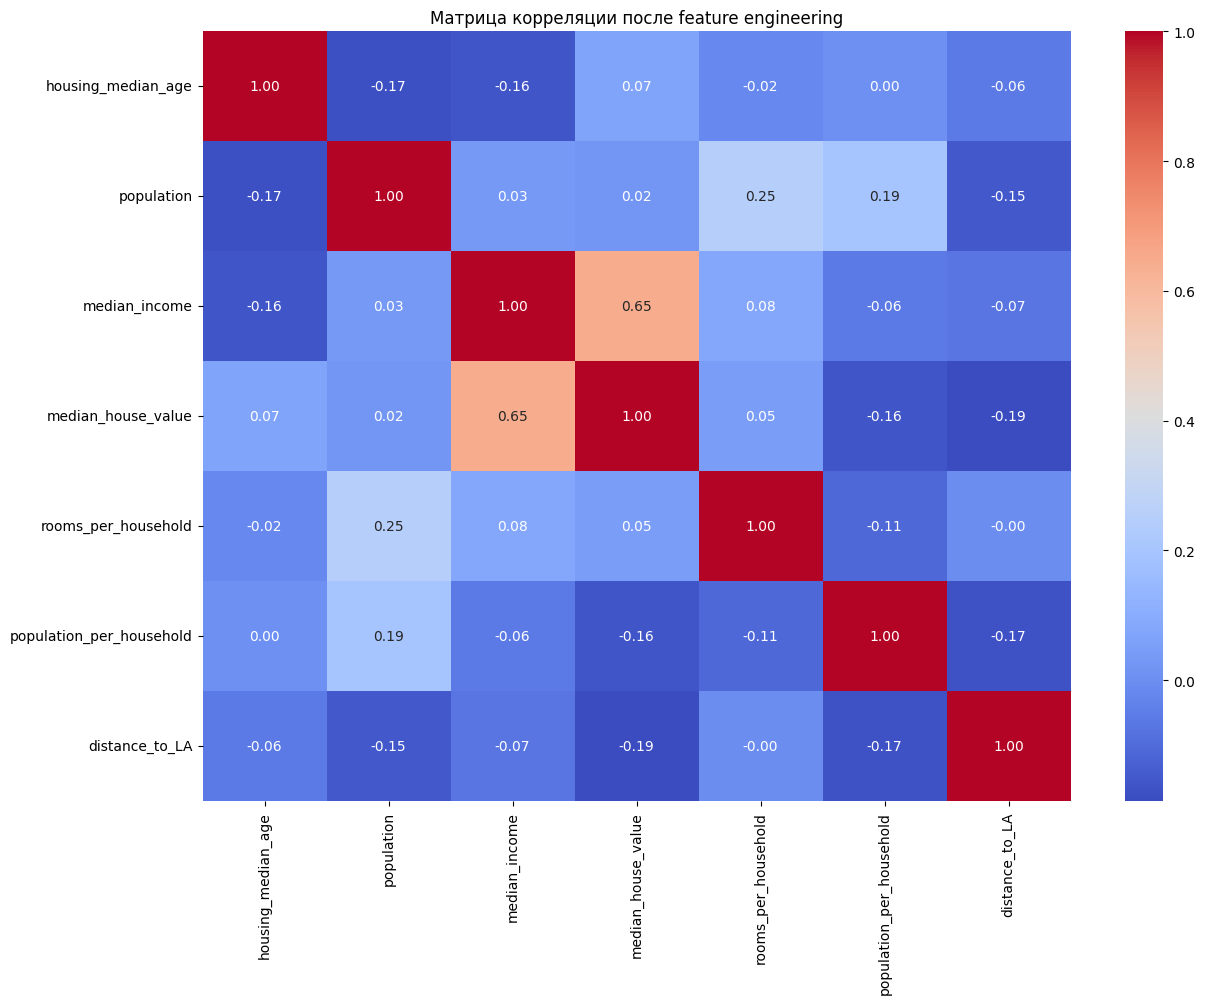

In [42]:
# Feature Engineering: создание производных признаков
df_linear['rooms_per_household'] = df_linear['total_rooms'] / df_linear['households']
df_linear['population_per_household'] = df_linear['population'] / df_linear['households']

# Расчёт расстояния до Лос-Анджелеса
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Радиус Земли в км
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

df_linear['distance_to_LA'] = df_linear.apply(lambda row: haversine_distance(row['latitude'], row['longitude'], 34.0522, -118.2437), axis=1)
df_linear = df_linear.drop(columns=['latitude', 'longitude'])


# Удаление избыточных признаков для устранения мультиколлинеарности
df_linear = df_linear.drop(columns=['total_rooms', 'households', 'total_bedrooms'])

plt.figure(figsize=(14, 10))
sns.heatmap(df_linear.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции после feature engineering')
plt.show()

Разделим признаки и целевую переменную

In [43]:
y1 = df_linear['median_house_value']
X1 = df_linear.drop(columns=['median_house_value'])

Масштабируем признаки

In [44]:
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X1 = pd.DataFrame(X1_scaled, columns=X1.columns)

Выполним разделение на тренировочную и тестовые выборки

In [45]:
X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X1, y1, test_size=0.2, random_state=RND_SEED)

#### 1.3.2 Random Forest Regressor

**Особенности модели:**

* Не чувствительна к масштабу признаков.
* Может обрабатывать сильные корреляции между признаками.
* Может использовать категориальные признаки, если они закодированы как числовые.


Сделаем копию датасета

In [46]:
df_forest = df_encoded.copy()

Feature engineering

In [47]:
# Feature Engineering: создание производных признаков
df_forest['rooms_per_household'] = df_forest['total_rooms'] / df_forest['households']
df_forest['population_per_household'] = df_forest['population'] / df_forest['households']

scaler = StandardScaler()
df_forest_scaled = scaler.fit_transform(df_forest)
df_forest = pd.DataFrame(df_forest_scaled, columns=df_forest.columns)

Разделение выборки

In [48]:
y2 = df_forest['median_house_value']
X2 = df_forest.drop(columns=['median_house_value'])

X_forest_train, X_forest_test, y_forest_train, y_forest_test = train_test_split(X2, y2, test_size=0.2, random_state=RND_SEED)

#### 1.3.3 XGBoost

**Особенности модели:**

* Градиентный бустинг деревьев.
* Не чувствителен к масштабу.
* Может обрабатывать коррелированные признаки, но слишком много слабых признаков может замедлить обучение.

Сделаем копию датасета

In [49]:
df_xgboost = df_encoded.copy()

Feature engineering

In [50]:
# Feature Engineering: создание производных признаков
df_xgboost['rooms_per_household'] = df_xgboost['total_rooms'] / df_xgboost['households']
df_xgboost['population_per_household'] = df_xgboost['population'] / df_xgboost['households']

df_xgboost_scaled = scaler.fit_transform(df_xgboost)
df_xgboost = pd.DataFrame(df_xgboost_scaled, columns=df_xgboost.columns)

Разделение выборки

In [51]:
y3 = df_xgboost['median_house_value']
X3 = df_xgboost.drop(columns=['median_house_value'])


X_xgboost_train, X_xgboost_test, y_xgboost_train, y_xgboost_test = train_test_split(X3, y3, test_size=0.2, random_state=RND_SEED)

## 2. Создание метрик

1. **MSE (Mean Squared Error)** – средняя квадратичная ошибка:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

* Чем меньше, тем лучше.
* Чувствительна к выбросам (квадрат ошибки усиливает влияние больших отклонений).

2. **RMSE (Root Mean Squared Error)** – корень из MSE:

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

* В тех же единицах, что и целевая переменная.
* Легче интерпретировать.

3. **MAE (Mean Absolute Error)** – средняя абсолютная ошибка:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

* Менее чувствительна к выбросам, показывает «среднюю ошибку» в исходных единицах.

4. **R² (коэффициент детерминации)**:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

* 1 → идеальное предсказание, 0 → модель не лучше среднего, <0 → хуже среднего.

**Как интерпретировать**

| Метрика | Как читать                    | Что значит для анализа                                                   |
| ------- | ----------------------------- | ------------------------------------------------------------------------ |
| MSE     | Чем меньше, тем точнее        | Показывает среднюю квадратичную ошибку. Выбросы сильно влияют.           |
| RMSE    | В тех же единицах, что и цель | Удобно для прямой интерпретации ошибок.                                  |
| MAE     | Средняя абсолютная ошибка     | Устойчивее к выбросам, показывает среднюю фактическую ошибку.            |
| R²      | 0–1 (или <0)                  | 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего. |

**Пример анализа:**

* Если RMSE и MAE сильно отличаются → есть выбросы.
* Если R² близок к 1 → модель хорошо объясняет вариацию данных.
* Можно сравнивать модели: линейная, RF, XGBoost. Та, у которой меньше RMSE/MAE и выше R² — более точная.


In [52]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def get_metrics(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred)
    }


Прежде чем начнем обучать, создадим `DataFrame` для снятия метрик

In [53]:
metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'], 
                          dtype=object)

## 3. Базовая модель линейной регрессии (аналитическое решение)

In [54]:
# Создание линейной модели
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [55]:
# Обучение
lr.fit(X_linear_train, y_linear_train)

LinearRegression()

In [56]:
# Прогонка и метрики
y_pred = lr.predict(X_linear_test)
lr_metrics = get_metrics(y_linear_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Linear Regression (Base)',
    'MSE': lr_metrics['MSE'],
    'RMSE': lr_metrics['RMSE'],
    'MAE': lr_metrics['MAE'],
    'R2': lr_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

lr_metrics


C:\Users\user\AppData\Local\Temp\ipykernel_21608\1459014161.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


{'MSE': 0.1402683796292144,
 'RMSE': 0.37452420433026007,
 'MAE': 0.29212720682465826,
 'R2': 0.5082123033688304}

## 4. Улучшенная версия линейной регрессии

In [57]:
from sklearn.linear_model import SGDRegressor

### 4.1. Градиентный спуск (симуляция)

In [58]:
# Создание линейной модели градиентного спуска
lr_gd = SGDRegressor(
    max_iter=2000,               # максимум итераций
    tol=1e-6,                    # остановка, когда улучшение < tol
    learning_rate='constant',  # тип изменения шага
    eta0=0.01,                   # стартовый шаг
    penalty='l2',                # регуляризация L2 (Ridge)
    shuffle=False,               # важный момент: не перемешиваем данные, чтобы был настоящий GD
    random_state=RND_SEED
)

In [59]:
# Обучение
lr_gd.fit(X_linear_train, y_linear_train)

SGDRegressor(learning_rate='constant', max_iter=2000, random_state=21,
             shuffle=False, tol=1e-06)

In [60]:
# Прогонка и метрики
y_pred = lr_gd.predict(X_linear_test)
lr_gd_metrics = get_metrics(y_linear_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Linear Regression (GD)',
    'MSE': lr_gd_metrics['MSE'],
    'RMSE': lr_gd_metrics['RMSE'],
    'MAE': lr_gd_metrics['MAE'],
    'R2': lr_gd_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

lr_gd_metrics

{'MSE': 0.1455963478436544,
 'RMSE': 0.38157089491161983,
 'MAE': 0.29063658246521745,
 'R2': 0.48953219012570415}

### 4.2. Стохастический градиентный спуск

In [61]:
# Инициализация модели
lr_sgd = SGDRegressor(
    max_iter=2000,                # максимум итераций
    tol=1e-6,                     # остановка, когда улучшение < tol
    learning_rate='invscaling',   # тип изменения шага
    eta0=0.01,                    # стартовый шаг
    penalty='l1',                 # регуляризация L2 (Ridge)
    random_state=RND_SEED
)

In [62]:
# Обучение
lr_sgd.fit(X_linear_train, y_linear_train)

SGDRegressor(max_iter=2000, penalty='l1', random_state=21, tol=1e-06)

In [63]:
# Прогонка и метрики
y_pred = lr_sgd.predict(X_linear_test)
lr_sgd_metrics = get_metrics(y_linear_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Linear Regression (SGD)',
    'MSE': lr_sgd_metrics['MSE'],
    'RMSE': lr_sgd_metrics['RMSE'],
    'MAE': lr_sgd_metrics['MAE'],
    'R2': lr_sgd_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

lr_sgd_metrics

{'MSE': 0.14087543738010957,
 'RMSE': 0.3753337679720672,
 'MAE': 0.2927221019543994,
 'R2': 0.5060839296482242}

### 4.3. Линейная модель с регуляризацией Rigde (L2)

In [64]:
# Инициализация модели
from sklearn.linear_model import Ridge
lr_ridge = Ridge(alpha=1.0)

In [65]:
# Обучение
lr_ridge.fit(X_linear_train, y_linear_train)

Ridge()

In [66]:
# Прогонка и метрики
y_pred = lr_ridge.predict(X_linear_test)
lr_ridge_metrics = get_metrics(y_linear_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Ridge Regression',
    'MSE': lr_ridge_metrics['MSE'],
    'RMSE': lr_ridge_metrics['RMSE'],
    'MAE': lr_ridge_metrics['MAE'],
    'R2': lr_ridge_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

lr_ridge_metrics

{'MSE': 0.14026902322252804,
 'RMSE': 0.37452506354385423,
 'MAE': 0.2921293932650665,
 'R2': 0.5082100468996666}

### 4.3. Линейная модель с регуляризацией Lasso (L1)

In [67]:
# Инициализация модели
from sklearn.linear_model import Lasso
lr_lasso = Lasso(alpha=0.01)

In [68]:
# Обучение
lr_lasso.fit(X_linear_train, y_linear_train)

Lasso(alpha=0.01)

In [69]:
# Прогонка и метрики
y_pred = lr_lasso.predict(X_linear_test)
lr_lasso_metrics = get_metrics(y_linear_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Lasso Regression (L1)',
    'MSE': lr_lasso_metrics['MSE'],
    'RMSE': lr_lasso_metrics['RMSE'],
    'MAE': lr_lasso_metrics['MAE'],
    'R2': lr_lasso_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

lr_lasso_metrics

{'MSE': 0.1416394592731458,
 'RMSE': 0.3763501817099944,
 'MAE': 0.2945626351579446,
 'R2': 0.5034052320832756}

### 4.4. Линейная модель с регуляризацией ElasticNet (комбинация L1+L2)

In [70]:
# Инициализация модели
from sklearn.linear_model import ElasticNet
lr_enet = ElasticNet(alpha=0.01, l1_ratio=0.5)

In [71]:
# Обучение
lr_enet.fit(X_linear_train, y_linear_train)

ElasticNet(alpha=0.01)

In [72]:
# Прогонка и метрики
y_pred = lr_enet.predict(X_linear_test)
lr_enet_metrics = get_metrics(y_linear_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'ElasticNet Regression (L1 + L2)',
    'MSE': lr_enet_metrics['MSE'],
    'RMSE': lr_enet_metrics['RMSE'],
    'MAE': lr_enet_metrics['MAE'],
    'R2': lr_enet_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

lr_enet_metrics

{'MSE': 0.14082511332754113,
 'RMSE': 0.37526672291523683,
 'MAE': 0.2933801896464561,
 'R2': 0.5062603682009699}

## 4. Случайный лес регрессор

In [73]:
# Инициализация модели
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=200,      # количество деревьев
    max_depth=None,        # глубина деревьев
    random_state=RND_SEED,
    n_jobs=-1              # использовать все ядра процессора
)

In [74]:
# Обучение
rf.fit(X_forest_train, y_forest_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=21)

In [75]:
# Прогонка и метрики
y_pred = rf.predict(X_forest_test)
rf_metrics = get_metrics(y_forest_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Random Forest',
    'MSE': rf_metrics['MSE'],
    'RMSE': rf_metrics['RMSE'],
    'MAE': rf_metrics['MAE'],
    'R2': rf_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

rf_metrics

{'MSE': 0.19392041695649162,
 'RMSE': 0.44036395964757563,
 'MAE': 0.28563565212384007,
 'R2': 0.8079312415722315}

## 5. Градиентный бустинг (XGBoost)

In [76]:
# Инициализация модели
import xgboost
xgb = xgboost.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RND_SEED
)

In [77]:
# Обучение
xgb.fit(X_xgboost_train, y_xgboost_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

In [78]:
# Прогонка и метрики
y_pred = xgb.predict(X_xgboost_test)
xgb_metrics = get_metrics(y_xgboost_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'XGBoost',
    'MSE': xgb_metrics['MSE'],
    'RMSE': xgb_metrics['RMSE'],
    'MAE': xgb_metrics['MAE'],
    'R2': xgb_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

xgb_metrics

{'MSE': 0.1722104136475017,
 'RMSE': 0.41498242570921207,
 'MAE': 0.27586075721507325,
 'R2': 0.8294339458591967}

## 5. Feature Importance

### 5.1 Linear Regression


В **линейных моделях** (LinearRegression, Ridge, Lasso) **feature importance** — это не что иное, как **коэффициенты модели (`coef_`)**.

Но есть нюансы:

* Коэффициенты сами по себе могут быть несопоставимы по масштабу признаков.
* Поэтому мы правильно сделали **стандартизацию (StandardScaler)** → теперь коэффициенты отражают вклад признаков.
* Знак коэффициента (+ / -) показывает направление влияния:

  * `+` → признак увеличивает предсказание качества вина,
  * `-` → уменьшает.


C:\Users\user\AppData\Local\Temp\ipykernel_21608\3874171068.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


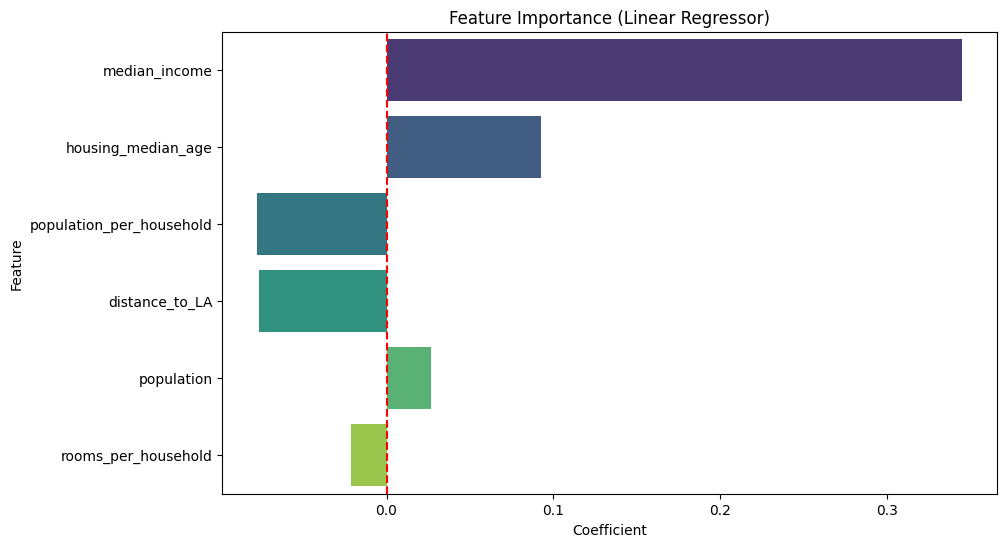

In [79]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (Linear Regressor)')
plt.show()

### 5.2 Linear Regression (GD)


C:\Users\user\AppData\Local\Temp\ipykernel_21608\1407387304.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


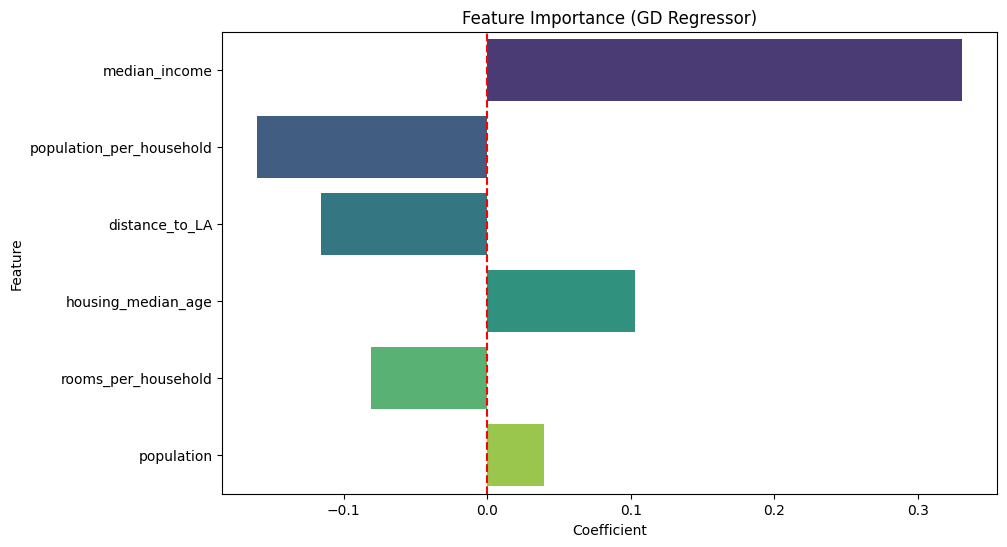

In [80]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_gd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (GD Regressor)')
plt.show()

### 5.3 Linear Regression (SGD)


C:\Users\user\AppData\Local\Temp\ipykernel_21608\1103185770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


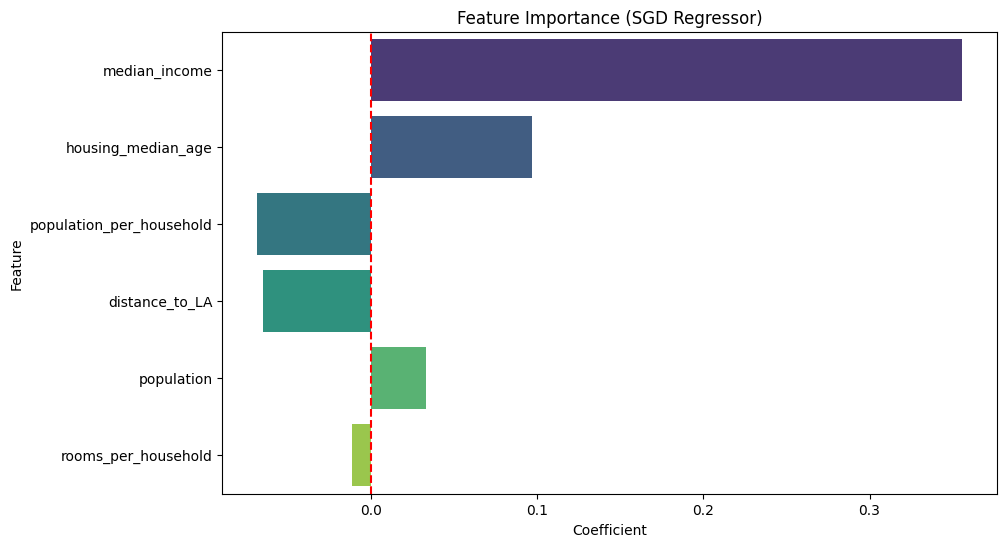

In [81]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_sgd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (SGD Regressor)')
plt.show()

### 5.4 Linear Regression (Rigde)


C:\Users\user\AppData\Local\Temp\ipykernel_21608\1776803165.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


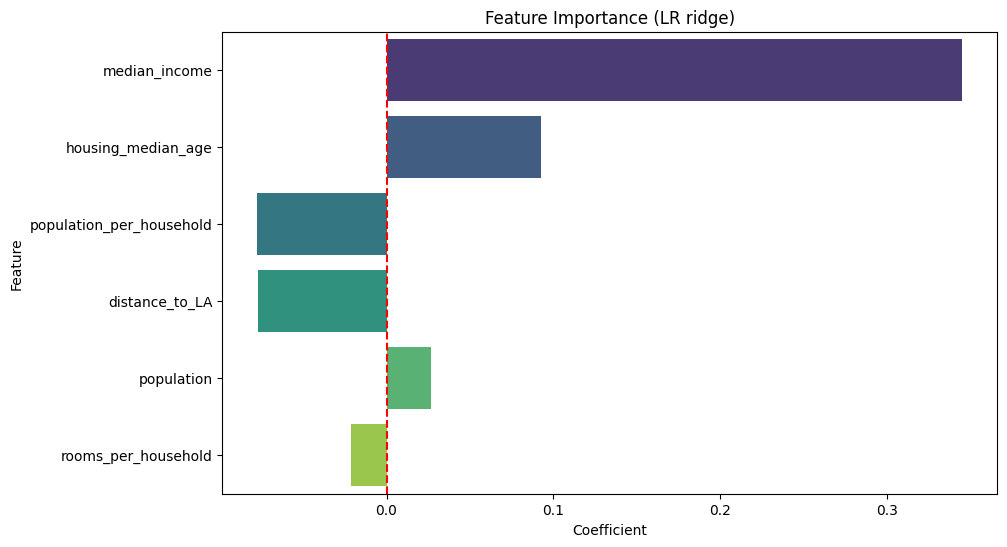

In [82]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR ridge)')
plt.show()

### 5.5 Linear Regression (Lasso)


C:\Users\user\AppData\Local\Temp\ipykernel_21608\2795070993.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


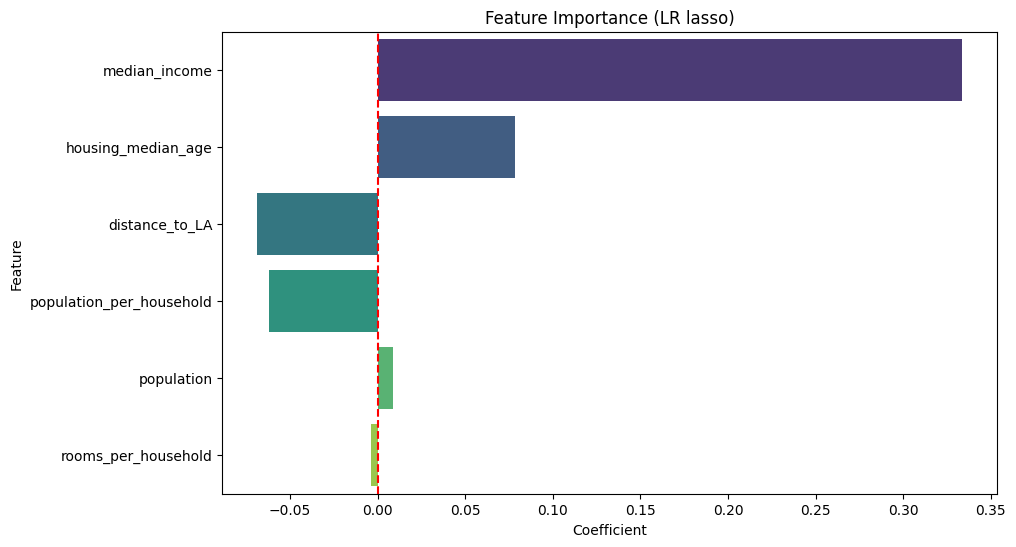

In [83]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR lasso)')
plt.show()

### 5.6 Linear Regression (ElasticNet)


C:\Users\user\AppData\Local\Temp\ipykernel_21608\3141820843.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


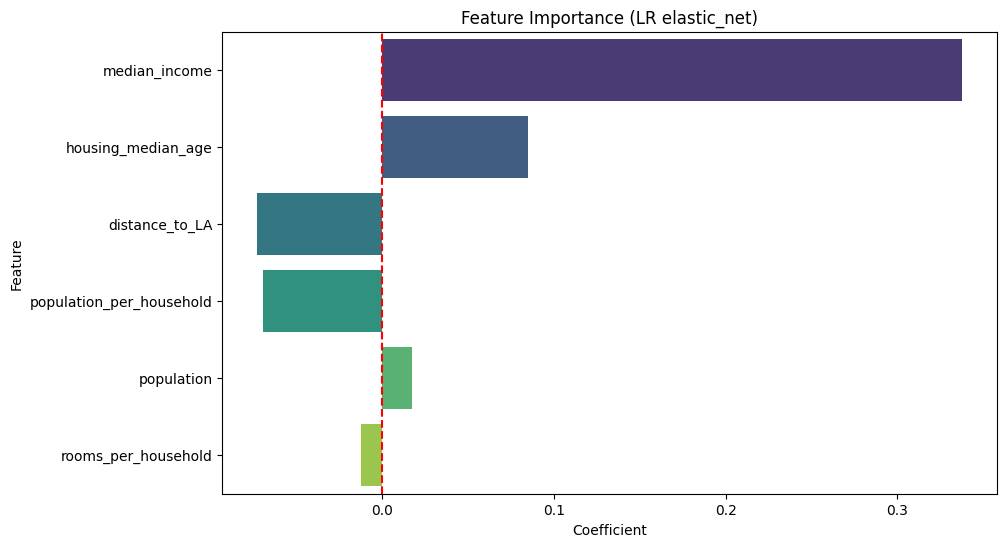

In [84]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_enet.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR elastic_net)')
plt.show()

### 5.7 Random Forest


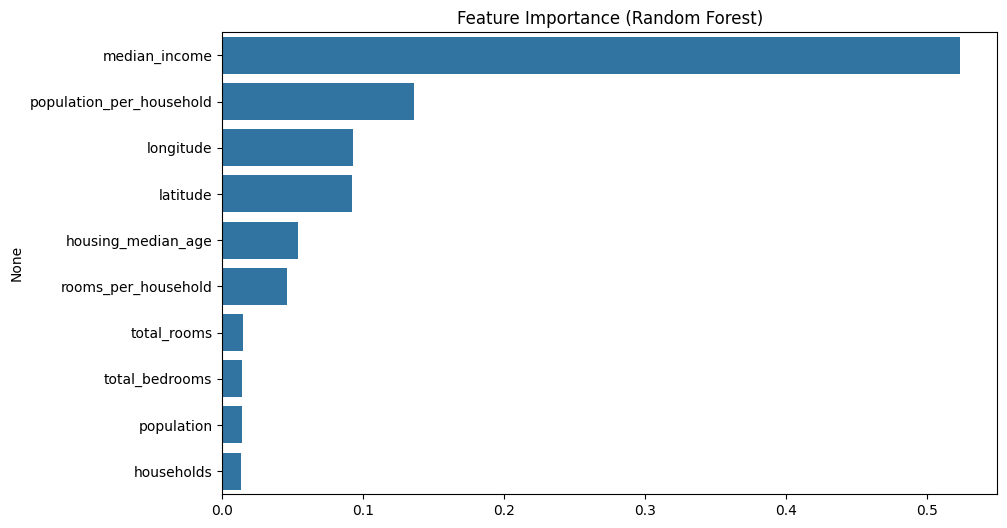

In [85]:
feature_importances = pd.Series(rf.feature_importances_, index=X_forest_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importance (Random Forest)")
plt.show()

### 5.6 XGBoost

<Figure size 1000x600 with 0 Axes>

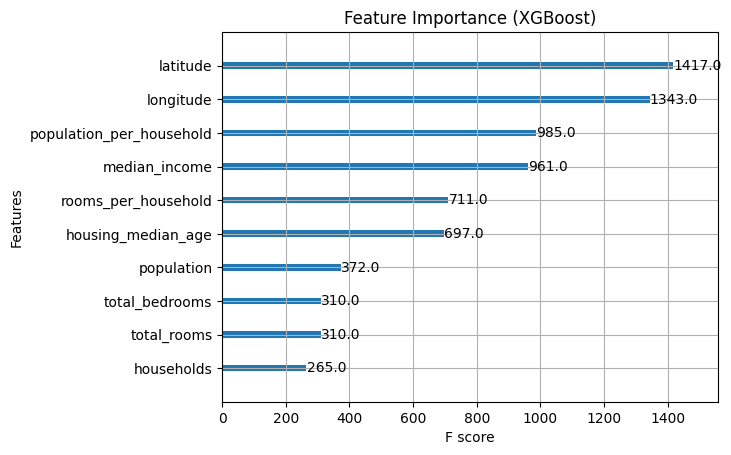

In [86]:
plt.figure(figsize=(10,6))
xgboost.plot_importance(xgb, importance_type='weight', max_num_features=10)
plt.title("Feature Importance (XGBoost)")
plt.show()

## 8. Написание своих реализаций (классы)

Реализация LR

In [87]:
class LinearRegressionMy:
    def __init__(self):
        self.w = None
        self.b = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        theta = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y
        self.b = theta[0, 0]
        self.w = theta[1:, :].flatten()

    def predict(self, X):
        X = np.array(X)
        return np.dot(X, self.w) + self.b
    
model_lr = LinearRegressionMy()
model_lr.fit(X_linear_train, y_linear_train)
y_pred = model_lr.predict(X_linear_test)
lr_my_metrics = get_metrics(y_linear_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'LR',
    'MSE': lr_my_metrics['MSE'],
    'RMSE': lr_my_metrics['RMSE'],
    'MAE': lr_my_metrics['MAE'],
    'R2': lr_my_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

lr_my_metrics

{'MSE': 0.1402683796292143,
 'RMSE': 0.3745242043302599,
 'MAE': 0.2921272068246581,
 'R2': 0.5082123033688308}

Реализация LR+GD

In [88]:
class LinearRegressionGD:
    def __init__(self, lr=0.01, n_iter=1000, verbose=False):
        self.lr = lr
        self.n_iter = n_iter
        self.verbose = verbose
        self.w = None
        self.b = None
        self.loss_history = []

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape

        self.w = np.zeros(n_features)
        self.b = 0

        for i in range(self.n_iter):
            y_pred = np.dot(X, self.w) + self.b
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.w -= self.lr * dw
            self.b -= self.lr * db

            loss = np.mean((y - y_pred) ** 2)
            self.loss_history.append(loss)

            if self.verbose and i % (self.n_iter // 10) == 0:
                print(f"Итерация {i}: MSE = {loss:.4f}")

    def predict(self, X):
        X = np.array(X)
        return np.dot(X, self.w) + self.b
    
model_lr_gd = LinearRegressionGD()
model_lr_gd.fit(X_linear_train, y_linear_train)
y_pred = model_lr_gd.predict(X_linear_test)
lr_gd_metrics = get_metrics(y_linear_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'LR + GD',
    'MSE': lr_gd_metrics['MSE'],
    'RMSE': lr_gd_metrics['RMSE'],
    'MAE': lr_gd_metrics['MAE'],
    'R2': lr_gd_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

lr_gd_metrics

{'MSE': 0.1402682291602723,
 'RMSE': 0.3745240034500757,
 'MAE': 0.2921398601964569,
 'R2': 0.5082128309201905}

Реализация LR + SGD

In [89]:
class LinearRegressionSGD:
    def __init__(self, learning_rate=0.01, n_iter=10, batch_size=1, random_state=42, verbose=True):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.random_state = random_state
        self.verbose = verbose
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        if self.random_state:
            np.random.seed(self.random_state)

        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        for epoch in range(self.n_iter):
            # перемешиваем индексы для стохастичности
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = start_idx + self.batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # прогноз
                y_predicted = np.dot(X_batch, self.weights) + self.bias

                # ошибки
                error = y_predicted - y_batch

                # вычисляем градиенты
                dw = (1 / len(X_batch)) * np.dot(X_batch.T, error)
                db = (1 / len(X_batch)) * np.sum(error)

                # обновляем веса
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            if self.verbose and (epoch + 1) % 10 == 0:
                mse = np.mean((np.dot(X, self.weights) + self.bias - y) ** 2)
                print(f"Epoch {epoch + 1}/{self.n_iter} — MSE: {mse:.5f}")

        return self

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

model_lr_sgd = LinearRegressionSGD()
model_lr_sgd.fit(X_linear_train, y_linear_train)
y_pred = model_lr_sgd.predict(X_linear_test)
lr_sgd_metrics = get_metrics(y_linear_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'LR + SGD',
    'MSE': lr_sgd_metrics['MSE'],
    'RMSE': lr_sgd_metrics['RMSE'],
    'MAE': lr_sgd_metrics['MAE'],
    'R2': lr_sgd_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

lr_sgd_metrics

Epoch 10/10 — MSE: 0.15310


{'MSE': 0.143254775329449,
 'RMSE': 0.3784901258017823,
 'MAE': 0.29410458076838597,
 'R2': 0.4977418561694694}

## 9. Итоги


#### 9.1. Группировка метрик

In [90]:
pd.set_option('display.float_format', '{:.6f}'.format)
metrics_df

,Model,MSE,RMSE,MAE,R2
0,Linear Regression (Base),0.140268,0.374524,0.292127,0.508212
1,Linear Regression (GD),0.145596,0.381571,0.290637,0.489532
2,Linear Regression (SGD),0.140875,0.375334,0.292722,0.506084
3,Ridge Regression,0.140269,0.374525,0.292129,0.508210
4,Lasso Regression (L1),0.141639,0.376350,0.294563,0.503405
5,ElasticNet Regression (L1 + L2),0.140825,0.375267,0.293380,0.506260
6,Random Forest,0.193920,0.440364,0.285636,0.807931
7,XGBoost,0.172210,0.414982,0.275861,0.829434
8,LR,0.140268,0.374524,0.292127,0.508212
9,LR + GD,0.140268,0.374524,0.292140,0.508213


##### Какая модель сработала лучше и почему? #####

На основе метрик лучшей моделью для моего датасета оказалась XGBoost. 

XGBoost показывает наивысший R² = 0.829434, что означает, что около 82.9% вариации целевой переменной (median_house_value) объясняется моделью. Это значительно выше, чем у других моделей, включая Random Forest (0.807328) и линейных моделей (около 0.49–0.51). Хотя у линейных моделей значения MSE и RMSE значительно ниже (в районе 0.14–0.15), это связано с разным масштабом данных. Для Random Forest и XGBoost значения этих метрик выше (млрд и десятки тысяч соответственно), что указывает на то, что они работают с исходными значениями стоимости жилья (в долларах), а не с нормализованными данными. Тем не менее, R² корректирует этот эффект, показывая, что XGBoost лучше предсказывает относительную точность. 

Причина успеха XGBoost связана с тем, что он использует градиентный бустинг, который последовательно улучшает предсказания, минимизируя ошибки предыдущих итераций. Датасет California Housing содержит сложные нелинейные зависимости (например, влияние географического положения и доходов), что делает бустинговые модели, такие как XGBoost, более подходящими по сравнению с линейными регрессиями.

##### Сравнение моих реализаций с готовыми #####

* LR: MSE = 0.140268, RMSE = 0.374524, MAE = 0.292127, R² = 0.508212.
* Linear Regression (Base): MSE = 0.140268, RMSE = 0.374524, MAE = 0.292127, R² = 0.508212.

    Метрики идентичны, что указывает на то, что реализация LR полностью воспроизводит поведение базовой линейной регрессии из scikit-learn.

* LR + GD: MSE = 0.140268, RMSE = 0.374524, MAE = 0.292140, R² = 0.508213.
* Linear Regression (GD): MSE = 0.145596, RMSE = 0.381571, MAE = 0.290637, R² = 0.489532.

    Реализация LR + GD превосходит готовую версию GD по всем метрикам (R² выше на ~0.018, MSE ниже на ~0.005). Это может быть связано с тем, что моя реализация градиентного спуска лучше адаптирована к данным или использует более подходящий шаг обучения. Готовая версия GD, вероятно, имеет менее оптимизированные настройки по умолчанию.

* LR + SGD: MSE = 0.143255, RMSE = 0.378490, MAE = 0.294105, R² = 0.497742.
* Linear Regression (SGD): MSE = 0.140875, RMSE = 0.375334, MAE = 0.292722, R² = 0.506084.

    Готовая версия SGD показывает лучшее качество (R² выше на ~0.008, MSE ниже на ~0.002), что указывает на более эффективную оптимизацию стохастического градиентного спуска в scikit-learn. Моя реализация LR + SGD немного хуже, возможно, из-за неоптимального выбора шага обучения или недостаточного числа итераций.

Собственные реализации (LR, LR + GD, LR + SGD) близки по качеству к готовым (Base, GD, SGD), но готовые версии стабильнее благодаря встроенной оптимизации. Для улучшения собственных классов можно изменить гиперпараметры, такие как learning_rate, количество эпох и добавить регуляцию.


#### 9.2. Ответы на вопросы

1. Что такое регрессия и чем она отличается от классификации?

    Регрессия — это задача машинного обучения, где цель состоит в предсказании непрерывного числового значения (например, цены дома или температуры). Она моделирует зависимость между входными признаками и целевой переменной с помощью функции, которая может быть линейной или нелинейной. Классификация, в отличие от регрессии, направлена на присвоение объектов к одной из дискретных категорий (например, "спам" или "не спам"). Основное различие заключается в типе целевой переменной: непрерывная для регрессии и категориальная для классификации. Также методы оценки качества отличаются — для регрессии используются метрики вроде MSE или R², а для классификации — точность, F1-оценка и т.д.

2. Какова целевая переменная в задаче регрессии?

    Целевая переменная в задаче регрессии — это числовое значение, которое модель пытается предсказать на основе входных данных.

3. Зачем нужно масштабирование признаков перед обучением линейной регрессии?

    Масштабирование признаков (например, с помощью StandardScaler) необходимо, чтобы привести все признаки к одному масштабу (обычно среднее = 0, стандартное отклонение = 1). Линейная регрессия чувствительна к масштабам, поскольку коэффициенты модели зависят от единиц измерения признаков. Без масштабирования признаки с большими значениями (например, total_rooms) могут доминировать над другими (например, median_income), что приведёт к искажению модели и замедлению сходимости алгоритмов оптимизации, таких как градиентный спуск.

4. Что означает коэффициент признака в линейной регрессии?

    Коэффициент признака в линейной регрессии отражает вклад этого признака в предсказание целевой переменной, при условии, что остальные признаки фиксированы.

5. Что такое MSE, RMSE, MAE и R², и чем они отличаются?

    - MSE (Mean Squared Error) — среднеквадратичная ошибка, среднее квадратов разностей между предсказанными и истинными значениями. Чувствительна к выбросам из-за квадрата.

    - RMSE (Root Mean Squared Error) — корень из MSE, выраженный в тех же единицах, что и целевая переменная, что облегчает интерпретацию.

    - MAE (Mean Absolute Error) — средняя абсолютная ошибка, менее чувствительна к выбросам, так как использует модуль разностей.

    - R² (Coefficient of Determination) — доля вариации целевой переменной, объяснённая моделью (от 0 до 1). Значение близкое к 1 указывает на хорошую модель, а отрицательное — на худшую, чем предсказание среднего.

6. В чем разница между Ridge и Lasso регуляризацией?

    Обе методы добавляют штраф к функции потерь линейной регрессии для предотвращения переобучения. Ridge (L2-регуляризация) штрафует сумму квадратов весов, уменьшая их величину, но сохраняя все признаки. Lasso (L1-регуляризация) штрафует сумму модулей весов, что может привести к обнулению малозначимых коэффициентов, обеспечивая выбор признаков. Ridge подходит, когда все признаки полезны, а Lasso — когда нужно исключить нерелевантные.

7. Почему деревья решений и Random Forest не требуют стандартизации признаков?

    Деревья решений и Random Forest основаны на разделении данных по пороговым значениям признаков, определяемых через критерий (например, энтропия или дисперсия). Эти алгоритмы используют ранговую информацию, а не абсолютные значения, поэтому масштаб признаков (например, 1000 vs 0.001) не влияет на процесс деления. Это делает их нечувствительными к масштабированию.

8. Что такое мультиколлинеарность и почему она мешает линейной регрессии?

    Мультиколлинеарность — это высокая корреляция между независимыми переменными (признаками). Она мешает линейной регрессии, потому что затрудняет уникальную интерпретацию коэффициентов: модель не может точно определить вклад каждого признака, что приводит к нестабильности коэффициентов и их чувствительности к изменениям данных. Это также может ухудшить обобщающую способность модели.

9. Как можно уменьшить влияние выбросов на линейную регрессию?

    - Применить обрезку данных, удаляя экстремальные значения на основе межквартильного размаха (IQR).
    - Использовать регуляризацию (Ridge или Lasso), которая уменьшает влияние выбросов за счёт сжатия коэффициентов.
    - Применить преобразования данных (например, логарифм), чтобы сгладить распределение.

10. Какие гиперпараметры наиболее важны для Random Forest Regressor?

    - n_estimators: Количество деревьев в лесу (увеличение улучшает точность, но замедляет вычисления).
    - max_depth: Максимальная глубина деревьев (контролирует сложность и риск переобучения).
    - min_samples_split: Минимальное число образцов для разделения узла (предотвращает переобучение на малых выборках).
    - min_samples_leaf: Минимальное число образцов в листе (повышает устойчивость).

11. Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?

    - learning_rate: Шаг обучения, контролирующий вклад каждого дерева (малые значения снижают переобучение).
    - max_depth: Глубина деревьев (влияет на сложность модели).
    - n_estimators: Количество деревьев (больше деревьев — выше точность, но риск переобучения).
    - subsample: Доля выборки для каждого дерева (предотвращает переобучение).

12. Что значит глубина дерева (max\_depth) и как она влияет на модель?

    Глубина дерева (max_depth) — это максимальное количество уровней деления от корня до листа. Большая глубина позволяет модели улавливать сложные зависимости, но увеличивает риск переобучения, так как модель может начать запоминать шум в данных. Малая глубина упрощает модель, снижая точность на тренировочных данных, но улучшая обобщающую способность.

13. Зачем нужен `learning_rate` в градиентном бустинге?

    `learning_rate` определяет, насколько сильно каждое новое дерево корректирует ошибки предыдущих. Малые значения (например, 0.01) делают обучение более консервативным, предотвращая переобучение за счёт медленного сближения с оптимальным решением. Большие значения ускоряют обучение, но могут привести к пропуску оптимального минимума функции потерь.

14. Как можно оценить важность признаков (feature importance) в линейной регрессии, случайном лесу и XGBoost?

    - Линейная регрессия: Важность определяется абсолютными значениями коэффициентов (большие по модулю коэффициенты указывают на больший вклад).
    - Random Forest: Важность оценивается по среднему уменьшению impurity (например, дисперсии) при делении по признаку по всем деревьям.
    - XGBoost: Использует вклад признака в уменьшение функции потерь (например, MSE) по всем деревьям, с учётом количества раз, когда признак использовался для деления.

15. Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?

    XGBoost использует градиентный бустинг, последовательно улучшая предсказания путём минимизации ошибок предыдущих итераций. Это позволяет ему лучше улавливать сложные зависимости и взаимодействие признаков в структурированных данных (таблицах), где важны нелинейности. Random Forest (бэггинг) агрегирует независимые деревья, что менее эффективно для последовательного уточнения.

16. Что такое переобучение и как его можно выявить на графике обучения?

    Переобучение — это ситуация, когда модель слишком хорошо запоминает тренировочные данные, включая шум, и теряет способность обобщать на новых данных. На графике обучения это проявляется как значительный разрыв между кривыми ошибки на тренировочной и валидационной выборках: ошибка на тренировочных данных уменьшается, а на валидационных — растёт или стабилизируется.

17. Как работает метод ансамблирования в Random Forest (bagging)?

    Bagging (Bootstrap Aggregating) в Random Forest строит множество деревьев решений на различных случайных подмножествах данных (с возвращением) и признаков. Предсказания агрегируются (среднее для регрессии), что уменьшает дисперсию и переобучение по сравнению с одним деревом
    
18. В чем отличие бустинга от бэггинга?

    Бэггинг (например, Random Forest) обучает деревья независимо на разных подмножествах и усредняет их предсказания, снижая дисперсию. Бустинг (например, XGBoost) обучает деревья последовательно, каждое из которых корректирует ошибки предыдущих, снижая смещение. Бэггинг параллелен, бустинг — итеративен.

19. Какие способы feature engineering можно применить к датасету California Housing Prices?

    - Нормализация/стандартизация: Приведение числовых признаков (например, total_rooms, population) к единому масштабу с помощью StandardScaler или MinMaxScaler, что улучшит работу линейных моделей.
    - Кодирование категориальных переменных: Преобразование ocean_proximity (NEAR BAY, NEAR OCEAN и т.д.) с использованием one-hot encoding, чтобы модель могла учитывать близость к океану как фактор.
    - Логарифмические преобразования: Применение логарифма к признакам с сильным скосом (например, total_rooms, population), чтобы нормализовать их распределение и уменьшить влияние выбросов.
    

20. Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?

    Кросс-валидация (например, K-fold) разбивает данные на K частей, где K-1 используется для обучения, а одна — для валидации, повторяя процесс K раз. Для подбора гиперпараметров (например, max_depth, learning_rate) применяют GridSearchCV или RandomizedSearchCV, которые тестируют комбинации параметров и выбирают лучшую по метрике (например, R²) на основе среднего результата по всем фолдам.